In [3]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB


In [4]:
N_ROOMS = 3  # number of rooms
N_SURGEONS = 5  # number of surgeons
N_INTERVENTIONS = 16  # number of interventions
T = 10  # max time in each room
W = 8  # max working hours per surgeon
H = 16

# ROOMS
K = {k for k in range(1, N_ROOMS+1)} # room set
T_max = {k: T for k in K}  # max time in each room

# SURGEONS
J = {j for j in range(1, N_SURGEONS+1)}  # surgeon set
s = {j: np.random.random() for j in J } # skill for each surgeon
a = {j: np.random.randint(30,60) for j in J}
a_min = min(a.values())
a_max = max(a.values())
a_norm = {j: (a[j] - a_min) / (a_max - a_min) for j in J}
W_max = {j: W for j in J}  # max working hours per surgeon
for j in J:
    print(f"Surgeon: {j}, age: {a[j]}, norm. age: {a_norm[j]}, skill_level: {s[j]}")

# INTERVENTIONS
I = {i for i in range(1, N_INTERVENTIONS+1)}  # intervention set
t = {i: np.random.randint(1, 3) for i in I}  # time for each intervention
d = {i: np.random.random() for i in I}  # duration for each intervention
for i in I:
    print(f"Intervention: {i}, difficulty: {d[i]}, duration: {t[i]}")



Surgeon: 1, age: 34, norm. age: 0.125, skill_level: 0.6274357352023093
Surgeon: 2, age: 33, norm. age: 0.08333333333333333, skill_level: 0.7791395517422147
Surgeon: 3, age: 31, norm. age: 0.0, skill_level: 0.44110105040738024
Surgeon: 4, age: 55, norm. age: 1.0, skill_level: 0.0400530849548042
Surgeon: 5, age: 32, norm. age: 0.041666666666666664, skill_level: 0.6408404627874495
Intervention: 1, difficulty: 0.11119830397600605, duration: 1
Intervention: 2, difficulty: 0.9828394466383593, duration: 2
Intervention: 3, difficulty: 0.7597091132034199, duration: 1
Intervention: 4, difficulty: 0.6507470743937472, duration: 2
Intervention: 5, difficulty: 0.10613571773418085, duration: 1
Intervention: 6, difficulty: 0.8349927157491955, duration: 1
Intervention: 7, difficulty: 0.42847514237086215, duration: 2
Intervention: 8, difficulty: 0.1640356630932125, duration: 2
Intervention: 9, difficulty: 0.9162226047309154, duration: 2
Intervention: 10, difficulty: 0.4011323358551041, duration: 2
Inter

In [5]:
import gurobipy as gp
from gurobipy import GRB

m = gp.Model("surgery scheduling")

# VARIABLES
x = m.addVars(I, J, vtype=GRB.BINARY, name="x")  # x[i,j] = 1 if intervention i is assigned to surgeon j
y = m.addVars(I, K, vtype=GRB.BINARY, name="y")  # y[i,k] = 1 if intervention i is assigned to room k
z = m.addVars(I, I,vtype=GRB.BINARY, name="z")  # z[i,j] = 1 if intervention i is assigned before intervention j
f = m.addVars(I, J, vtype=GRB.CONTINUOUS, lb = 0, ub = 1, name="f")  # f[i,j] = cumulative fatugue for surgeon j before intervention i
v = m.addVars(I, vtype=GRB.INTEGER, lb = 0, name="v")  # v[i] = start time for intervention i
p = m.addVars(I, I, J, vtype=GRB.BINARY, name="p")  # p[i,h,j] = 1 if intervention i is assigned before intervention h for surgeon j
#q = m.addVars(I, J, vtype=GRB.BINARY, name="q")  # linearizeation trick


# OBJECTIVE
#quality_obj = sum((d[i] * s[j] * x[i, j]) for i in I for j in J) - sum(((d[i] * s[j] * d[h] * t[h]) / W_max[j])*p[h,i,j] for i in I for h in I if i != h for j in J)
quality_obj = (sum(d[i] * s[j] * x[i, j] for i in I for j in J) - sum(a_norm[j] * f[i,j] for i in I for j in J)) / sum(d[i] for i in I)

m.setObjective(quality_obj, GRB.MAXIMIZE)

# CONSTRAINTS
# Each intervention is assigned to exactly one surgeon
for i in I:
    m.addConstr(sum(x[i,j] for j in J) == 1, name=f"one_surgeon_per_intervention_{i}")

# Each intervention is assigned to exactly one room
for i in I:
    m.addConstr(sum(y[i,k] for k in K) == 1, name=f"one_room_per_intervention_{i}")

# Each surgeon works at most W_max hours
for j in J:
    m.addConstr(sum(t[i] * x[i,j] for i in I) <= W_max[j], name=f"max_working_hours_{j}")

# Each room is used at most T_max hours
for k in K:
    m.addConstr(sum(t[i] * y[i,k] for i in I) <= T_max[k], name=f"max_time_per_room_{k}")

# Fatigue constraints
for i in I:
    for j in J:
        m.addConstr(f[i,j] == (1 / W_max[j]) * sum(d[h] * t[h] * p[h,i,j] for h in I), name=f"fatigue_constraint_{i}_{j}")


for h in I:
    for i in I:
        if h != i:
            for j in J:
                m.addConstr(p[h, i, j] <= x[h, j], name=f"p_leq_x_{h}_{i}_{j}")
                m.addConstr(p[h, i, j] <= z[h, i], name=f"p_leq_z_{h}_{i}_{j}")
                m.addConstr(p[h, i, j] >= x[h, j] + z[h, i] - 1, name=f"p_geq_xz_{h}_{i}_{j}")

# Start time constraints
for i in I:
    m.addConstr(v[i] + t[i] <= H, name=f"max_start_time_{i}")

for i in I:
    for h in I:
        if i != h:
            for j in J:
                m.addConstr(v[i] + t[i] <= v[h] + H * (1 - z[i,h]) + H * (2 - x[i,j] - x[h,j]), name=f"start_time_constraint_surgeon_{i}_{h}_{j}")
#
for i in I:
    for h in I:
        if i != h:
            for k in K:
                m.addConstr(v[i] + t[i] <= v[h] + H * (1 - z[i,h]) + H * (2 - y[i,k] - y[h,k]), name=f"start_time_constraint_room_{i}_{h}_{j}")


# Before-after constraints
for i in I:
    for h in I:
        if i != h:
            m.addConstr(z[i,h] + z[h,i] == 1, name=f"before_after_constraint_{i}_{h}")


m.update()
m.optimize()


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 20.6.0 20G1427)

CPU model: Intel(R) Core(TM) i5-4250U CPU @ 1.30GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 5896 rows, 1760 columns and 20112 nonzeros
Model fingerprint: 0x58926734
Variable types: 80 continuous, 1680 integer (1664 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+01]
  Objective range  [5e-04, 1e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Found heuristic solution: objective -0.1227809
Presolve removed 256 rows and 232 columns
Presolve time: 0.16s
Presolved: 5640 rows, 1528 columns, 19520 nonzeros
Variable types: 64 continuous, 1464 integer (1448 binary)

Root relaxation: objective 6.942676e-01, 1469 iterations, 0.23 seconds (0.07 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0    


Optimal Schedule Found!

    Intervention  Start   End  Duration  Difficulty  Surgeon  Room   Fatigue
4              5    0.0   1.0         1    0.106136        3     3  0.000000
15            16   -0.0   1.0         1    0.138023        1     2  0.000000
0              1    1.0   2.0         1    0.111198        3     1  0.013267
9             10    2.0   4.0         2    0.401132        3     3  0.027167
7              8    4.0   6.0         2    0.164036        3     3  0.127450
14            15    6.0   7.0         1    0.187317        2     3  0.000000
13            14    7.0   8.0         1    0.701982        2     2  0.023415
6              7    7.0   9.0         2    0.428475        5     3  0.000000
2              3    8.0   9.0         1    0.759709        2     2  0.111162
5              6    9.0  10.0         1    0.834993        2     2  0.206126
8              9   10.0  12.0         2    0.916223        2     2  0.310500
10            11   10.0  12.0         2    0.48790

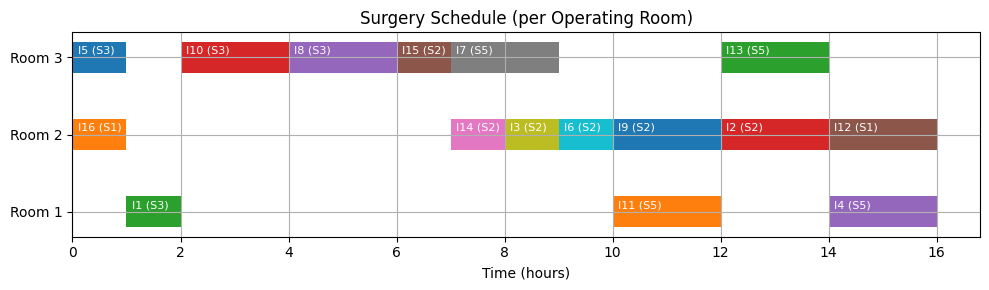

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

if m.status == GRB.OPTIMAL:
    print("\nOptimal Schedule Found!\n")

    # Build a dataframe for interventions
    schedule = []
    for i in I:
        start = v[i].X
        dur = t[i]
        diff = d[i]
        surgeon = [j for j in J if x[i, j].X > 0.5][0]
        room = [k for k in K if y[i, k].X > 0.5][0]
        fatigue = f[i, surgeon].X
        schedule.append({
            'Intervention': i,
            'Start': start,
            'End': start + dur,
            'Duration': dur,
            'Difficulty': diff,
            'Surgeon': surgeon,
            'Room': room,
            'Fatigue': fatigue
        })

    df = pd.DataFrame(schedule)
    df = df.sort_values("Start")
    print(df)

    # Optional Gantt chart: interventions per room
    # Create a mapping to ensure colors index properly
    #int_ids = list(df['Intervention'].unique())
    #int_index_map = {iid: idx for idx, iid in enumerate(int_ids)}
    #colors = plt.cm.viridis(np.linspace(0, 1, len(int_ids)))

    # Gantt chart
    fig, ax = plt.subplots(figsize=(10, len(K)))

    for idx, row in df.iterrows():
        ax.barh(y=row['Room'], left=row['Start'], width=t[row['Intervention']],
                height=0.4,
                label=f"Int {row['Intervention']} (Surgeon {row['Surgeon']})")
                #color=colors[int_index_map[row['Intervention']]])
        ax.text(row['Start'] + 0.1, row['Room'] + 0.05,
                f"I{int(row['Intervention'])} (S{int(row['Surgeon'])})",
                fontsize=8, color='white')

    ax.set_yticks(list(K))
    ax.set_yticklabels([f"Room {k}" for k in K])
    ax.set_xlabel("Time (hours)")
    ax.set_title("Surgery Schedule (per Operating Room)")
    ax.grid(True)
    plt.tight_layout()
    plt.show()


else:
    print("No optimal solution found.")
